In [70]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from numpy import mean
from numpy import std

import scipy
from scipy.stats import shapiro

import statsmodels
from statsmodels.graphics.gofplots import qqplot
from scipy import stats

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

encoder = preprocessing.LabelEncoder()

In [83]:
data = pd.read_csv("dataset_Facebook.csv", delimiter=';')

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Page total likes                                                     500 non-null    int64  
 1   Type                                                                 500 non-null    object 
 2   Category                                                             500 non-null    int64  
 3   Post Month                                                           500 non-null    int64  
 4   Post Weekday                                                         500 non-null    int64  
 5   Post Hour                                                            500 non-null    int64  
 6   Paid                                                                 499 non-null    float64
 7   Lifetime

### Pre-processing

In [85]:
data['like'].fillna(0,inplace=True)
data['share'].fillna(0,inplace=True)
data['Paid'].fillna(0,inplace=True)
data['Type'] = encoder.fit_transform(data['Type'].astype(str))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Page total likes                                                     500 non-null    int64  
 1   Type                                                                 500 non-null    int64  
 2   Category                                                             500 non-null    int64  
 3   Post Month                                                           500 non-null    int64  
 4   Post Weekday                                                         500 non-null    int64  
 5   Post Hour                                                            500 non-null    int64  
 6   Paid                                                                 500 non-null    float64
 7   Lifetime

### a) Shapiro-Wilk 
#### Lifetime Post Consumers

In [ ]:
data_mean, data_std = mean(data['Lifetime Post Consumers']), std(data['Lifetime Post Consumers'])

In [74]:
stat,p = shapiro(data['Lifetime Post Consumers'])
print('Statistics = %3.f, p = %3.f' % (stat, p))

Statistics =   1, p =   0


In [75]:
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Sample does not look Gaussian (reject H0)


/home/bryan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 4000.0)

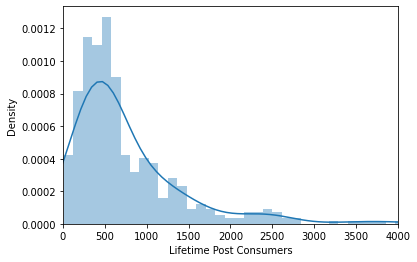

In [76]:
sns.distplot(data['Lifetime Post Consumers'],bins=100)
plt.xlim(0,4000)

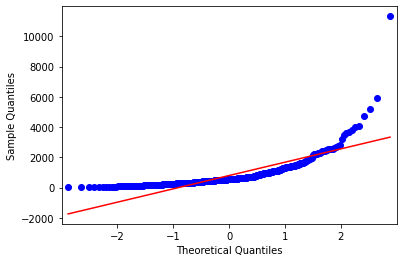

In [77]:
qqplot(data['Lifetime Post Consumers'], line='s')
plt.show()

mean=799 stdv=882


### b) Analisis descriptivo 

<AxesSubplot:>

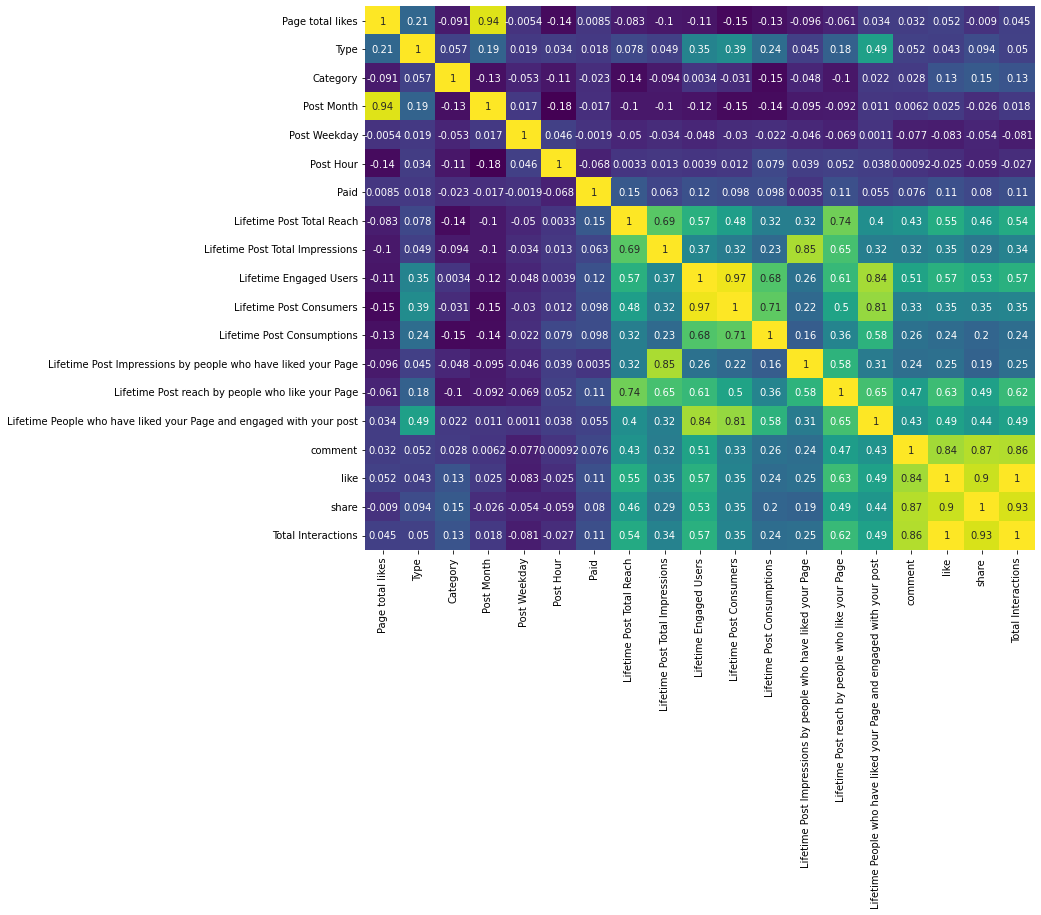

In [67]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(),cmap='viridis',annot=True,cbar=False)

Todas las métricas lifetime parecen tener una alta correlación con las métricas de participación: likes, comments, shares, total interactions (una suma de las 3 características anteriores). Esto sugiere que un modelo de regresión que predice el total de usuarios comprometidos podría tener un rendimiento adecuado.

### b) Transformaciones

In [92]:
def boxcox_transform(data_column):
    fitted_data, fitted_lambda = stats.boxcox(data_column)
    fig, ax = plt.subplots(1,2)
    
    #sns.histplot(data = data_column)
    sns.distplot(data_column, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2},
                label = "Non-Normal", color = "green", ax = ax[0])
    #sns.histplot(data = fitted_data)
    sns.distplot(fitted_data, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2}, 
                label = "Normal", color ="green", ax = ax[1])

    # adding legends to the subplots
    plt.legend(loc = "upper right")

    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)

    print(f"Lambda value used for Transformation: {fitted_lambda}")

/home/bryan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/bryan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Lambda value used for Transformation: 5.359719103102546


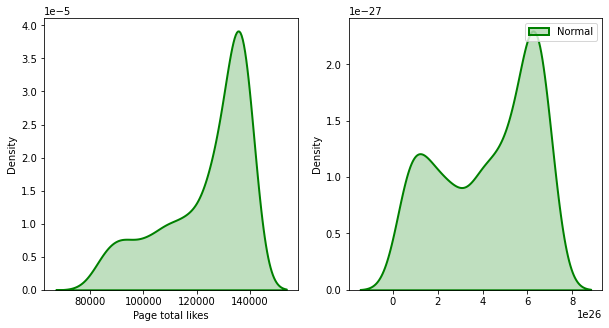

In [93]:
boxcox_transform(data['Page total likes'])

In [94]:
boxcox_transform(data['Type'])   

ValueError: Data must be positive.

In [ ]:
transform_variables(data['Category'])
transform_variables(data['Post Month'])
transform_variables(data['Post Weekday'])
transform_variables(data['Post Hour'])
transform_variables(data['Paid'])
transform_variables(data['Lifetime Post Consumers'])